<a href="https://colab.research.google.com/gist/abrusebas1997/38ab593c96cc73c2b3aba37719433d5b/sebastian_abarca_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data clustering for spotify songs**

My goal for this project is to make predictions about what are the most immportant features you need to have in mind if you want to enter the music industry on spotify


First, I need to use the dataset I'm going to use. In this case, I found [my dataset of spotify song](https://https://www.kaggle.com/edalrami/19000-spotify-songs?select=song_data.csv)s on Kaggle.com
Then, I will import the .csv file to Google Colab.

In [1]:
from google.colab import files
uploaded = files.upload()

Saving song_data.csv to song_data.csv


With this line of code, the uploaded dataset will be saved into Google Colab

In [2]:
import io
import pandas as pd

df = pd.read_csv(io.BytesIO(uploaded['song_data.csv']))

All my imports will be in this cell

In [86]:
# Imports
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.cluster import KMeans





**Analysis**

Taking a look at the dataset and checking if there are any null values

In [3]:
print(df.head(10))
df.isnull().sum() 

                    song_name  song_popularity  ...  time_signature  audio_valence
0  Boulevard of Broken Dreams               73  ...               4          0.474
1                  In The End               66  ...               4          0.370
2           Seven Nation Army               76  ...               4          0.324
3                  By The Way               74  ...               4          0.198
4           How You Remind Me               56  ...               4          0.574
5            Bring Me To Life               80  ...               4          0.320
6                 Last Resort               81  ...               4          0.724
7    Are You Gonna Be My Girl               76  ...               4          0.537
8              Mr. Brightside               80  ...               4          0.234
9                 Sex on Fire               81  ...               4          0.374

[10 rows x 15 columns]


song_name           0
song_popularity     0
song_duration_ms    0
acousticness        0
danceability        0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
audio_mode          0
speechiness         0
tempo               0
time_signature      0
audio_valence       0
dtype: int64

Getting the dimensions of this dataset(rows, columns)

In [4]:
print(df.shape)

(18835, 15)


Distributing data

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18835 entries, 0 to 18834
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_name         18835 non-null  object 
 1   song_popularity   18835 non-null  int64  
 2   song_duration_ms  18835 non-null  int64  
 3   acousticness      18835 non-null  float64
 4   danceability      18835 non-null  float64
 5   energy            18835 non-null  float64
 6   instrumentalness  18835 non-null  float64
 7   key               18835 non-null  int64  
 8   liveness          18835 non-null  float64
 9   loudness          18835 non-null  float64
 10  audio_mode        18835 non-null  int64  
 11  speechiness       18835 non-null  float64
 12  tempo             18835 non-null  float64
 13  time_signature    18835 non-null  int64  
 14  audio_valence     18835 non-null  float64
dtypes: float64(9), int64(5), object(1)
memory usage: 2.2+ MB
None


In [6]:
df.song_duration_ms= df.song_duration_ms.astype(float)
df.time_signature= df.time_signature.astype(float)
df.audio_mode= df.audio_mode.astype(float)

In [7]:
print(df.describe())

       song_popularity  song_duration_ms  ...  time_signature  audio_valence
count     18835.000000      1.883500e+04  ...    18835.000000   18835.000000
mean         52.991877      2.182116e+05  ...        3.959119       0.527967
std          21.905654      5.988754e+04  ...        0.298533       0.244632
min           0.000000      1.200000e+04  ...        0.000000       0.000000
25%          40.000000      1.843395e+05  ...        4.000000       0.335000
50%          56.000000      2.113060e+05  ...        4.000000       0.527000
75%          69.000000      2.428440e+05  ...        4.000000       0.725000
max         100.000000      1.799346e+06  ...        5.000000       0.984000

[8 rows x 14 columns]


Songs exceeding the score 50 are consider popular. The rest are unpopular


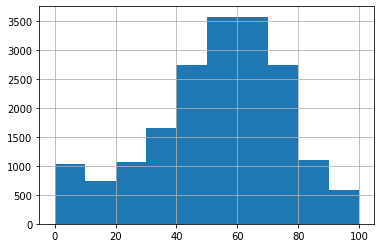

In [8]:
df['song_popularity'].hist()

11598 songs are consider popular. That represents 61.04% of the total
7237 songs are consider unpopular. That represents 38.96% of the total

In [44]:
df["popularity"]= [ 1 if i>=50 else 0 for i in df.song_popularity ]
df["popularity"].value_counts()

1    11598
0     7237
Name: popularity, dtype: int64

In [11]:
#popular songs' data
a=df[df["popularity"]==1]
a.describe()

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,popularity
count,8021.000000,8021.000000,8021.000000,8021.000000,8021.000000,8021.000000,8021.000000,8021.000000,8021.000000,8021.000000,8021.000000,8021.000000,8021.000000,8021.000000,8021.0
mean,72.494577,218146.245730,0.228803,0.649015,0.653317,0.038347,5.208453,0.175579,-6.909366,0.627353,0.103239,120.796864,3.969705,0.521211,1.0
std,9.400357,49595.126404,0.265454,0.150568,0.199781,0.154686,3.658309,0.138679,3.487277,0.483539,0.101505,28.170143,0.274348,0.234824,0.0
min,60.000000,50014.000000,0.000005,0.061700,0.001070,0.000000,0.000000,0.021500,-36.281000,0.000000,0.022400,46.591000,0.000000,0.027700,1.0
25%,65.000000,188857.000000,0.025100,0.551000,0.534000,0.000000,2.000000,0.092400,-8.211000,0.000000,0.038200,98.729000,4.000000,0.333000,1.0
50%,71.000000,212066.000000,0.117000,0.657000,0.679000,0.000002,5.000000,0.121000,-6.145000,1.000000,0.057000,119.964000,4.000000,0.514000,1.0
75%,78.000000,241226.000000,0.344000,0.757000,0.807000,0.000357,8.000000,0.211000,-4.694000,1.000000,0.124000,139.434000,4.000000,0.704000,1.0
max,100.000000,578040.000000,0.996000,0.980000,0.997000,0.969000,11.000000,0.978000,-0.257000,1.000000,0.869000,216.115000,5.000000,0.982000,1.0


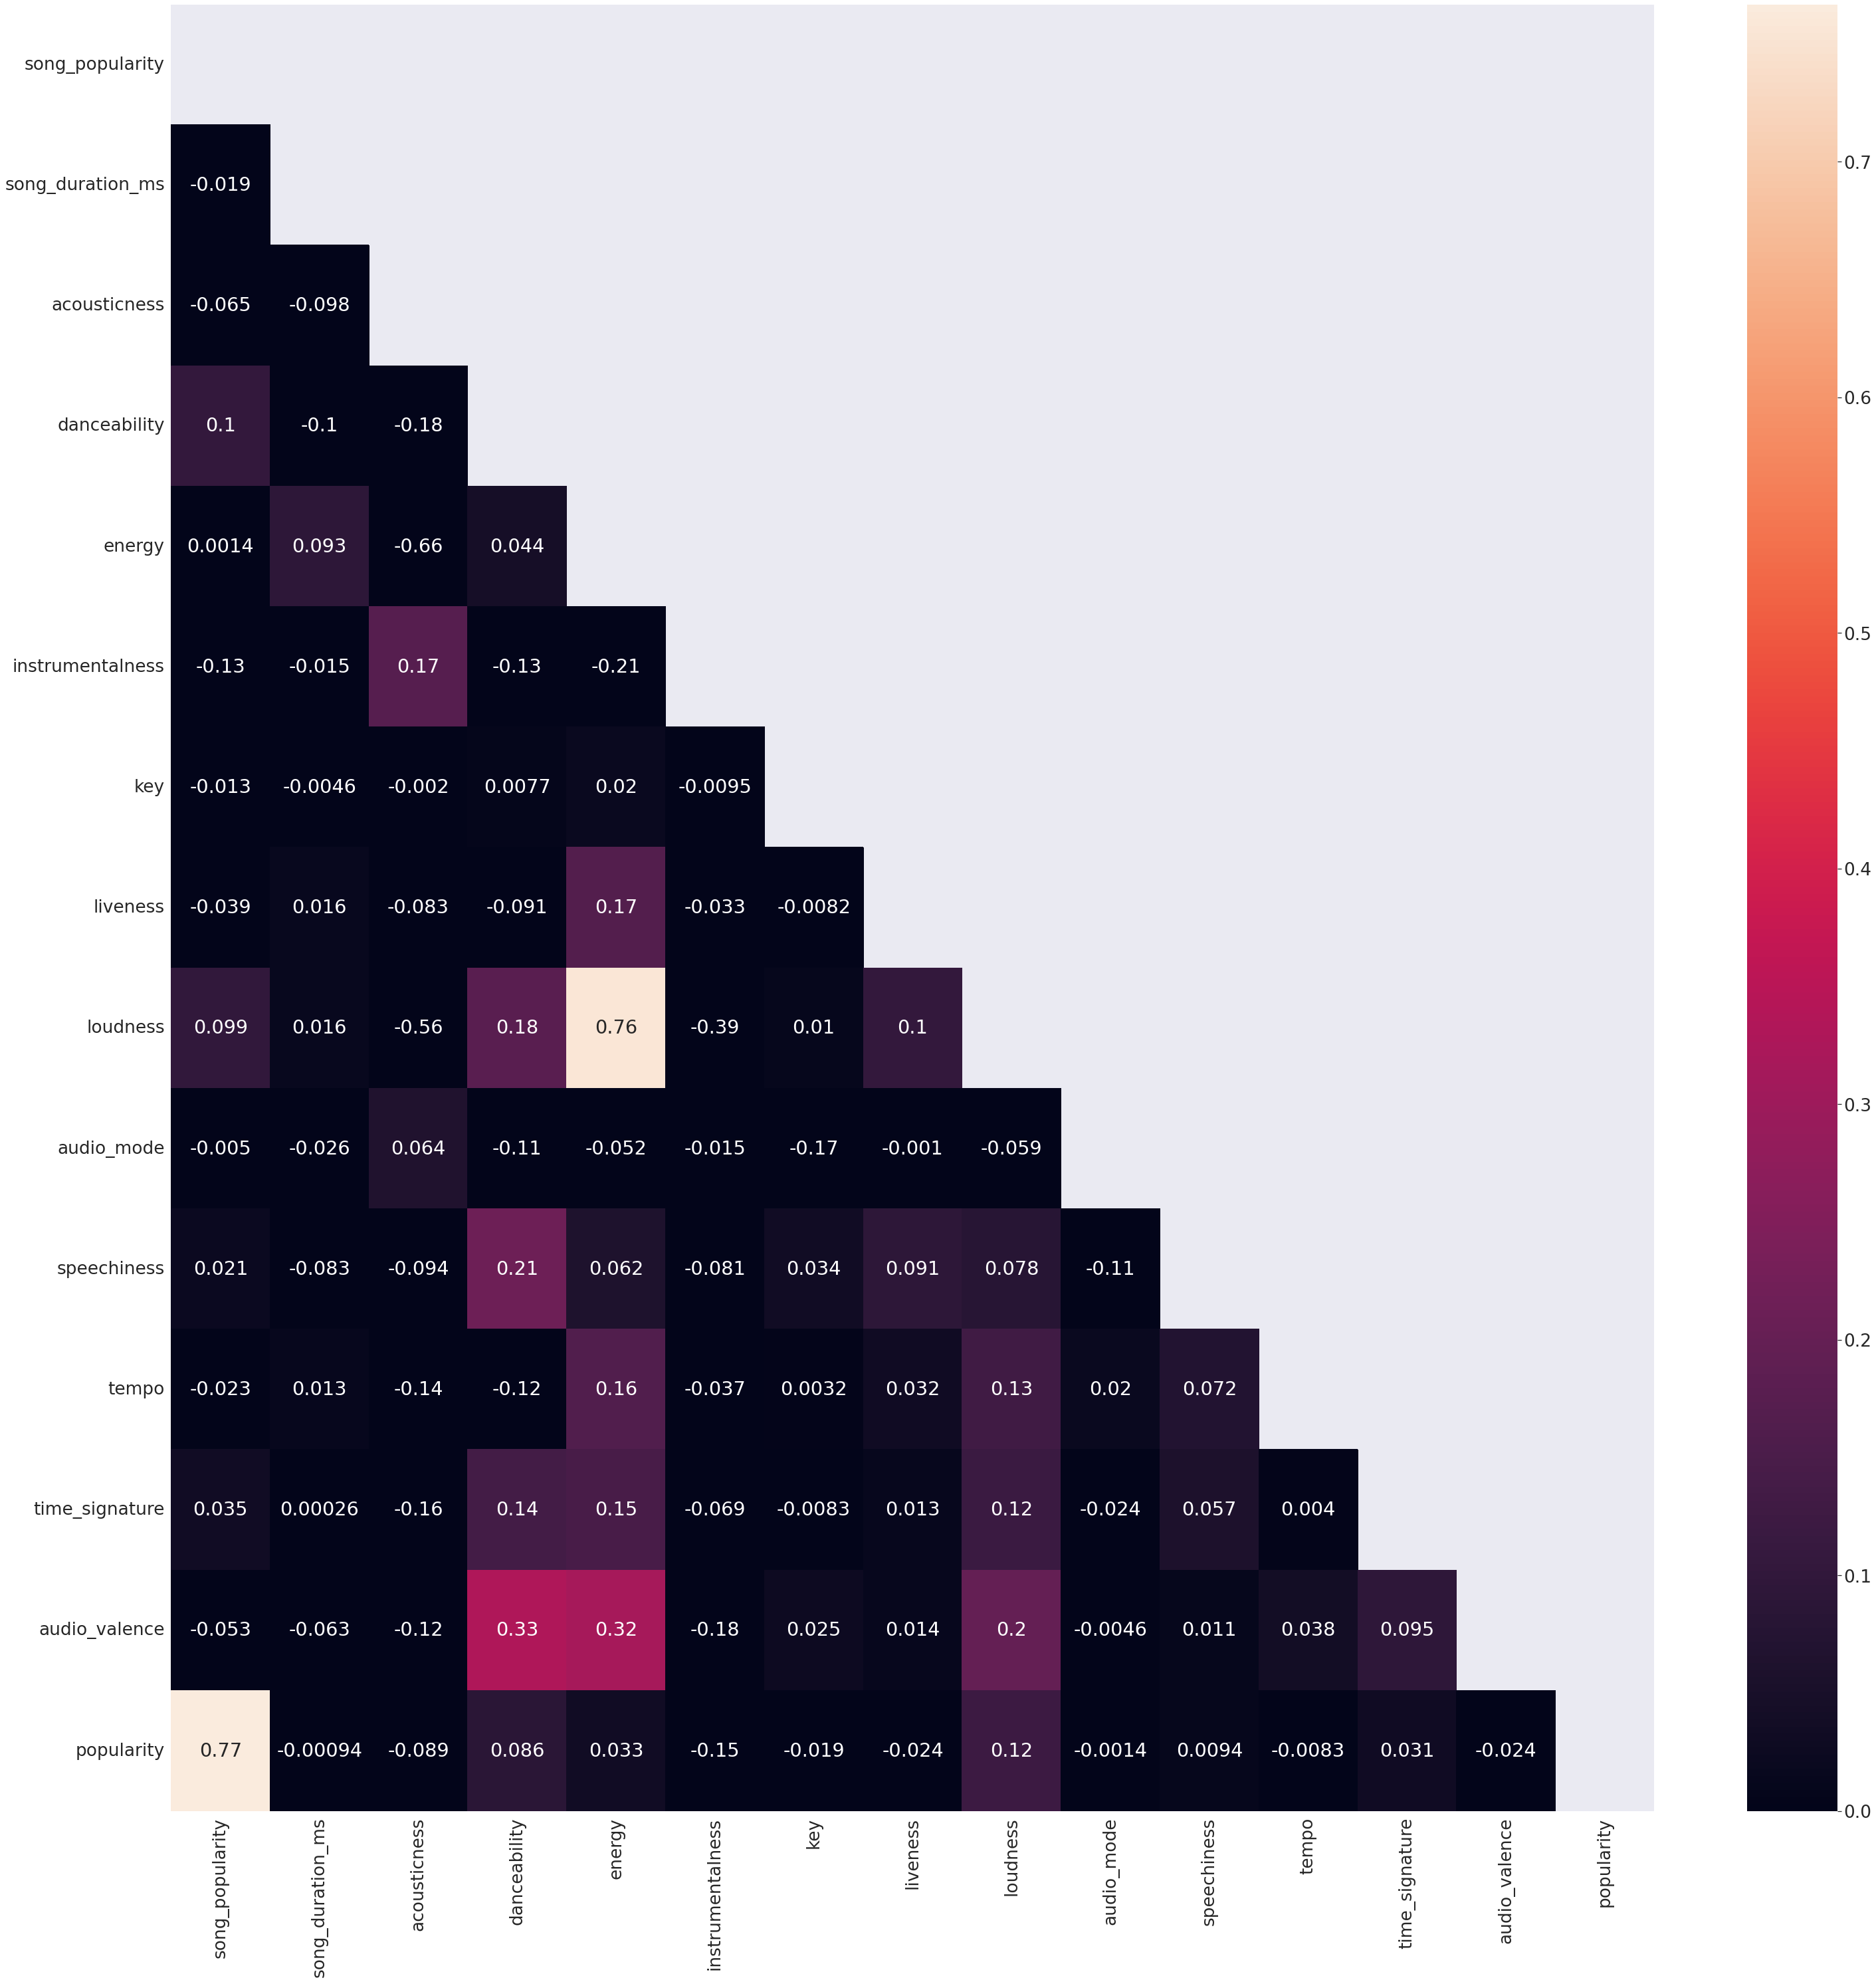

In [16]:
sns.set(rc={'figure.figsize':(50,50)})

feature_matrix = df.corr()

# Generate a mask to remove duplicate values
mask = np.triu(np.ones_like(feature_matrix, dtype=bool))
sns.set(font_scale=2.4)

sns.heatmap(feature_matrix, vmin=0, mask=mask, annot=True)


This correlation map shows us that the only strong correlation is happening between loudness and energy. When we compare song_popularity with other features, there is no strong correlation.

A very important step to have a more efficient prediction on a dataset is by doing data spliting and trainin your model

In [23]:
# feature_cols = ["energy", "loudness"]

# X = df[feature_cols]
# Y = df['popularity']

X = df.drop('song_name', axis=1)
y = df['popularity']

# Use 75% of the dataset for training and 25% for testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

In [24]:
std = StandardScaler()

X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

In [73]:
svm_classifier = SVC(kernel='linear', C=3)

In [74]:
svm_classifier.fit(X_train_std, Y_train)

# Run our SVM on unseen data
y_pred = svm_classifier.predict(X_test_std)

In [75]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# Create a confusion matrix and calculate accuracy metrics
confusion = confusion_matrix(Y_test, y_pred)
accuracy = accuracy_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)

print("Confusion matrix:", confusion)
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Confusion matrix: [[2699    0]
 [   0 2010]]
Accuracy: 1.0
F1 Score: 1.0
Precision: 1.0
Recall: 1.0


Most correlated features distribution

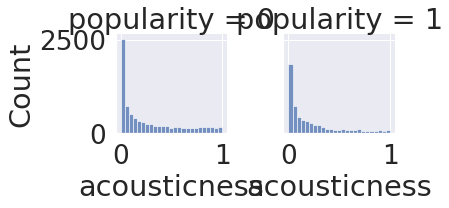

In [76]:
#I couldn't get these plots bigger, but we can appreciate when the charts are low or high 
f = sns.FacetGrid(X_train, col = "popularity")
f.map(sns.histplot, "acousticness", bins = 25)
plt.show()

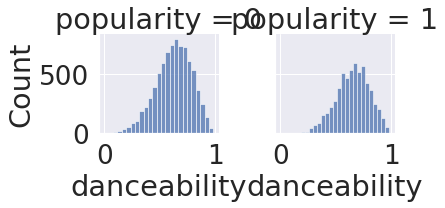

In [77]:
f = sns.FacetGrid(X_train, col = "popularity")
f.map(sns.histplot, "danceability", bins = 25)
plt.show()

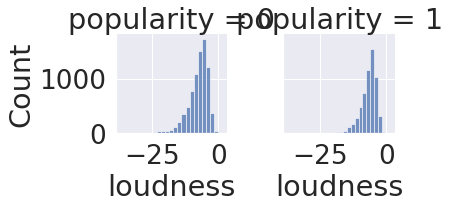

In [78]:
f = sns.FacetGrid(X_train, col = "popularity")
f.map(sns.histplot, "loudness", bins = 25)
plt.show()

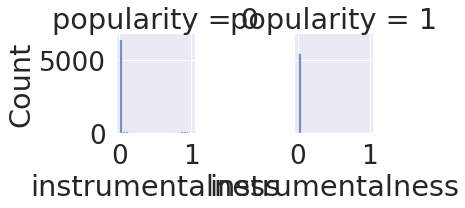

In [80]:
f = sns.FacetGrid(X_train, col = "popularity")
f.map(sns.histplot, "instrumentalness", bins = 25)
plt.show()

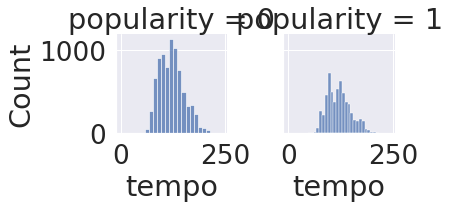

In [84]:
f = sns.FacetGrid(X_train, col = "popularity")
f.map(sns.histplot, "tempo", bins = 25)
plt.show()

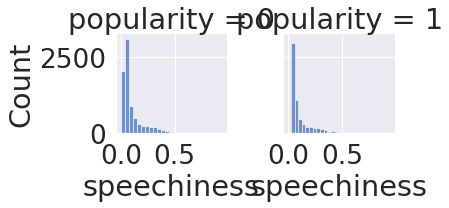

In [82]:
f = sns.FacetGrid(X_train, col = "popularity")
f.map(sns.histplot, "speechiness", bins = 25)
plt.show()


From the charts above, we can conclude that when songs are fast and loud, these are unpopular. Also, if a song is low instrumental, it becomes more popular.

On this part, I'll be scaling the data in order to fit a k-means object to it and thus to visualize the clustered data.


In [100]:
X_scaled = preprocessing.scale(df[['song_popularity','tempo']])
X_scaled

array([[ 0.91340135,  1.60156497],
       [ 0.59384067, -0.55085753],
       [ 1.05035593,  0.09778769],
       ...,
       [-1.36917494,  0.32948899],
       [ 0.09167389, -0.52275247],
       [ 0.31993152, -1.03028036]])

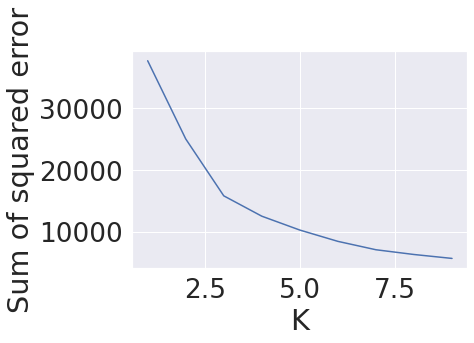

In [102]:
distortions = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(X_scaled)
    distortions.append(km.inertia_)
plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng,distortions)

Text(0.5, 1.0, 'K-Means Clustering')

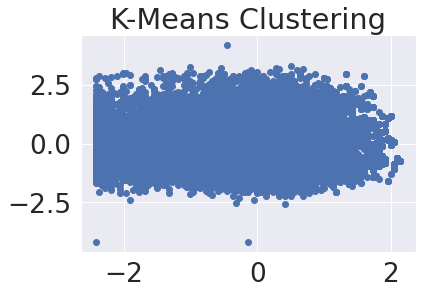

In [105]:
model_km = KMeans(n_clusters=2)
model_km.fit(X_scaled)

plt.scatter(X_scaled[:, 0], X_scaled[:, 1])
plt.title("K-Means Clustering")

In [107]:
from sklearn.decomposition import PCA

model_pca = PCA(n_components=2)
x_pca = model_pca.fit_transform(X_scaled)


print(model_pca.explained_variance_)
print(model_pca.explained_variance_ratio_)
print(model_pca.explained_variance_ratio_.cumsum())

[1.02272637 0.97737982]
[0.51133603 0.48866397]
[0.51133603 1.        ]


Text(0.5, 1.0, 'K-Means Clustering')

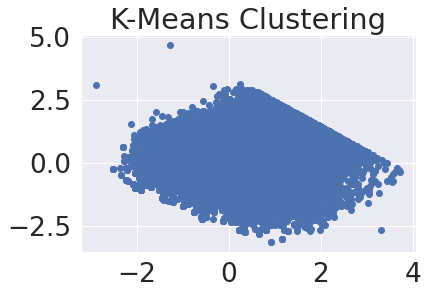

In [108]:
km_pca = KMeans(n_clusters=2)

km_pca.fit(x_pca)

plt.scatter(x_pca[:, 0], x_pca[:, 1])
plt.title("K-Means Clustering")

In conclusion, after applying PCA components on our K-means evaluation, we can notice that the songs that are clustered in tempo 3 are the most popular
